In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import warnings
import gc
from datetime import datetime
import json
from tqdm import tqdm
warnings.filterwarnings('ignore')

from sklearn.metrics import (
    f1_score, matthews_corrcoef, accuracy_score, confusion_matrix,
    precision_score, recall_score, classification_report,
    balanced_accuracy_score
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN

In [12]:
SEED = 42
np.random.seed(SEED)

ROOT = Path(r"C:\Computer Science\AIMLDL\log-anomaly-detection")
FEAT_PATH = ROOT / "features"
RES_PATH = ROOT / "results" / "ml_models_multiclass"
RES_PATH.mkdir(parents=True, exist_ok=True)

LABEL_MAP = {
    0: 'normal',
    1: 'security_anomaly',
    2: 'system_failure',
    3: 'performance_issue',
    4: 'network_anomaly',
    5: 'config_error',
    6: 'hardware_issue'
}

print(f"Classes: {len(LABEL_MAP)}")
print(f"Results path: {RES_PATH}")

Classes: 7
Results path: C:\Computer Science\AIMLDL\log-anomaly-detection\results\ml_models_multiclass


In [13]:
feat_file = FEAT_PATH / "pyspark_hybrid_features.pkl"
if not feat_file.exists():
    print(f"Error: {feat_file} not found")
    exit(1)

with open(feat_file, 'rb') as f:
    feat_data = pickle.load(f)
    dat = feat_data['hybrid_features_data']
    num_classes = feat_data.get('num_classes', 7)

print(f"\nLoaded features for {len(dat)} sources")

split_file = FEAT_PATH / "pyspark_cross_source_splits.pkl"
if not split_file.exists():
    print(f"Error: {split_file} not found")
    exit(1)

with open(split_file, 'rb') as f:
    split_data = pickle.load(f)
    splts = split_data['splits']

print(f"Loaded {len(splts)} cross-source splits")


Loaded features for 9 sources
Loaded 9 cross-source splits


In [14]:
optimal_config_file = ROOT / "dataset" / "labeled_data" / "normalized" / "optimal_class_config.json"
if optimal_config_file.exists():
    with open(optimal_config_file, 'r') as f:
        optimal_config = json.load(f)
    print(f"Loaded optimal class configuration")
    print(f"  Recommended classes: {optimal_config['num_recommended']}/7")
    print(f"  Requires SMOTE: {optimal_config['requires_smote']}")
    print(f"  Requires class weights: {optimal_config['requires_class_weights']}")
else:
    optimal_config = None
    print("\nNo optimal config found - using all 7 classes")

Loaded optimal class configuration
  Recommended classes: 5/7
  Requires SMOTE: True
  Requires class weights: True


In [15]:
mod_config = {
    'lr': {
        'model': LogisticRegression(random_state=SEED, max_iter=2000, multi_class='multinomial', n_jobs=1),
        'p': {'C': [0.1, 1.0, 10.0], 'solver': ['lbfgs']},
    },
    'rf': {
        'model': RandomForestClassifier(random_state=SEED, n_jobs=1),
        'p': {'n_estimators': [100, 200], 'max_depth': [10, 20]},
    },
    'xgb': {
        'model': XGBClassifier(random_state=SEED, eval_metric='mlogloss', n_jobs=1, 
                              tree_method='hist', objective='multi:softmax', num_class=7),
        'p': {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]},
    },
    'gb': {
        'model': GradientBoostingClassifier(random_state=SEED),
        'p': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]},
    },
    'svm': {
        'model': SVC(random_state=SEED, probability=True, decision_function_shape='ovr', cache_size=1000),
        'p': {'C': [1, 10], 'kernel': ['rbf'], 'gamma': ['scale']},
    },
    'knn': {
        'model': KNeighborsClassifier(n_jobs=1),
        'p': {'n_neighbors': [5, 7, 9], 'weights': ['uniform']},
    },
    'dt': {
        'model': DecisionTreeClassifier(random_state=SEED),
        'p': {'max_depth': [10, 20], 'min_samples_split': [2, 5]},
    },
    'nb': {
        'model': GaussianNB(),
        'p': {'var_smoothing': [1e-9, 1e-8]},
    }
}

print(f"Configured {len(mod_config)} models")

Configured 8 models


In [16]:
def calc_metrics(y_true, y_pred, y_proba=None):
    try:
        met = {}
        
        met['acc'] = accuracy_score(y_true, y_pred)
        met['bal_acc'] = balanced_accuracy_score(y_true, y_pred)
        
        met['f1_macro'] = f1_score(y_true, y_pred, average='macro', zero_division=0)
        met['f1_micro'] = f1_score(y_true, y_pred, average='micro', zero_division=0)
        met['f1_weighted'] = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        
        met['prec_macro'] = precision_score(y_true, y_pred, average='macro', zero_division=0)
        met['prec_weighted'] = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        
        met['rec_macro'] = recall_score(y_true, y_pred, average='macro', zero_division=0)
        met['rec_weighted'] = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        
        met['mcc'] = matthews_corrcoef(y_true, y_pred)
        
        cm = confusion_matrix(y_true, y_pred)
        met['confusion_matrix'] = cm.tolist()
        
        per_class_f1 = f1_score(y_true, y_pred, average=None, zero_division=0)
        met['per_class_f1'] = {int(i): float(f1) for i, f1 in enumerate(per_class_f1)}
        
        per_class_prec = precision_score(y_true, y_pred, average=None, zero_division=0)
        met['per_class_precision'] = {int(i): float(p) for i, p in enumerate(per_class_prec)}
        
        per_class_rec = recall_score(y_true, y_pred, average=None, zero_division=0)
        met['per_class_recall'] = {int(i): float(r) for i, r in enumerate(per_class_rec)}
        
        return met
    except Exception as e:
        print(f"Error calculating metrics: {e}")
        return {'acc': 0, 'bal_acc': 0, 'f1_macro': 0, 'f1_micro': 0, 'f1_weighted': 0}

In [17]:
def apply_sampling(X_tr, y_tr, imbalance_info):
    print("Analyzing class distribution...")
    
    unique, counts = np.unique(y_tr, return_counts=True)
    class_dist = dict(zip(unique, counts))
    
    print(f"  Classes present: {len(unique)}")
    for cls, count in class_dist.items():
        pct = (count / len(y_tr) * 100)
        print(f"    {int(cls)} ({LABEL_MAP[int(cls)]}): {count} ({pct:.2f}%)")
    
    if len(unique) < 2:
        print("  Only 1 class present - cannot train")
        return None, None
    
    max_count = max(counts)
    min_count = min(counts)
    imb_ratio = max_count / min_count
    
    print(f"\n  Imbalance ratio: {imb_ratio:.2f}:1")
    
    if imb_ratio < 3:
        print("  Balanced - no sampling needed")
        return X_tr, y_tr
    
    minority_classes = [cls for cls, count in class_dist.items() if count < len(y_tr) * 0.1]
    
    if minority_classes:
        print(f"  Minority classes (<10%): {[LABEL_MAP[int(c)] for c in minority_classes]}")
    
    min_samples_for_smote = min(counts)
    
    if min_samples_for_smote <= 1:
        print("  Classes with ≤1 sample - cannot apply SMOTE")
        return X_tr, y_tr
    
    k_neighbors = min(5, min_samples_for_smote - 1)
    
    if k_neighbors < 1:
        print("  Insufficient samples for SMOTE")
        return X_tr, y_tr
    
    try:
        if imb_ratio > 100:
            print(f"  EXTREME imbalance - using BorderlineSMOTE with k={k_neighbors}")
            sampler = BorderlineSMOTE(random_state=SEED, k_neighbors=k_neighbors)
        elif imb_ratio > 10:
            print(f"  HIGH imbalance - using SMOTE with k={k_neighbors}")
            sampler = SMOTE(random_state=SEED, k_neighbors=k_neighbors)
        else:
            print(f"  MODERATE imbalance - using SMOTE with k={k_neighbors}")
            sampler = SMOTE(random_state=SEED, k_neighbors=k_neighbors)
        
        X_res, y_res = sampler.fit_resample(X_tr, y_tr)
        
        print(f"  Sampling complete: {len(y_tr)} → {len(y_res)} samples")
        
        unique_after, counts_after = np.unique(y_res, return_counts=True)
        print(f"  New distribution:")
        for cls, count in zip(unique_after, counts_after):
            pct = (count / len(y_res) * 100)
            print(f"    {int(cls)} ({LABEL_MAP[int(cls)]}): {count} ({pct:.2f}%)")
        
        return X_res, y_res
        
    except Exception as e:
        print(f"  Sampling failed: {e}")
        print("  → Proceeding with original data + class weights")
        return X_tr, y_tr

In [18]:
def train_model(m_name, m_config, X_tr, y_tr, X_ts, y_ts, class_weights):
    try:
        n_spl = min(3, max(2, len(y_tr) // 50))
        
        if hasattr(m_config['model'], 'class_weight'):
            m_config['model'].set_params(class_weight=class_weights)
        
        if len(m_config['p']) > 0:
            cv = StratifiedKFold(n_splits=n_spl, shuffle=True, random_state=SEED)
            
            grid = GridSearchCV(
                m_config['model'],
                m_config['p'],
                cv=cv,
                scoring='f1_macro',
                n_jobs=1,
                verbose=0
            )
            grid.fit(X_tr, y_tr)
            b_mod = grid.best_estimator_
            b_par = grid.best_params_
        else:
            b_mod = m_config['model']
            b_mod.fit(X_tr, y_tr)
            b_par = {}
        
        y_pred = b_mod.predict(X_ts)
        
        y_prob = None
        try:
            y_prob = b_mod.predict_proba(X_ts)
        except AttributeError:
            pass
        
        met = calc_metrics(y_ts, y_pred, y_prob)
        
        return m_name, {
            'm': met,
            'p': b_par,
            'mod': b_mod,
            'class_weights': class_weights
        }
        
    except Exception as e:
        print(f"  Error training {m_name}: {e}")
        return m_name, {'e': str(e)}


In [19]:
def run_exp(split, feat_type, dat, s_config):
    test_src = split['test_source']
    train_srcs = split['train_sources']
    
    print(f"\n{'='*80}")
    print(f"EXPERIMENT: Test on {test_src}")
    print(f"{'='*80}")
    
    if test_src not in dat or dat[test_src]['labels'] is None:
        return None
    
    if feat_type not in dat[test_src]['feature_variants']:
        return None
    
    test_data = dat[test_src]
    X_ts = test_data['feature_variants'][feat_type]
    y_ts = test_data['labels']
    
    X_tr_list, y_tr_list = [], []
    for src in train_srcs:
        if src in dat and dat[src]['labels'] is not None:
            if feat_type in dat[src]['feature_variants']:
                X_tr_list.append(dat[src]['feature_variants'][feat_type])
                y_tr_list.append(dat[src]['labels'])
    
    if not X_tr_list:
        return None
    
    X_tr = np.vstack(X_tr_list)
    y_tr = np.concatenate(y_tr_list)
    
    print(f"\nTraining data: {len(y_tr):,} samples from {len(train_srcs)} sources")
    print(f"Test data: {len(y_ts):,} samples")
    
    if len(np.unique(y_tr)) < 2:
        print("Insufficient classes in training data")
        return None
    
    sc = StandardScaler()
    X_tr_sc = sc.fit_transform(X_tr)
    X_ts_sc = sc.transform(X_ts)
    
    imbalance_info = {
        'test_source': test_src,
        'train_sources': train_srcs
    }
    
    X_tr_res, y_tr_res = apply_sampling(X_tr_sc, y_tr, imbalance_info)
    
    if X_tr_res is None or y_tr_res is None:
        print("Sampling failed - cannot proceed")
        return None
    
    class_weight_values = compute_class_weight('balanced', classes=np.unique(y_tr_res), y=y_tr_res)
    class_weights = {int(cls): float(w) for cls, w in zip(np.unique(y_tr_res), class_weight_values)}
    
    print(f"\n  Class weights:")
    for cls, weight in sorted(class_weights.items()):
        print(f"    {cls} ({LABEL_MAP[cls]}): {weight:.4f}")
    
    print(f"\n  Training {len(s_config)} models...")
    sup_res = {}
    for name, config in tqdm(s_config.items(), desc="Models"):
        name, res = train_model(name, config, X_tr_res, y_tr_res, X_ts_sc, y_ts, class_weights)
        sup_res[name] = res
        gc.collect()
    
    exp_name = f"{test_src}_{feat_type}"
    
    res = {
        'sup': sup_res,
        'ts_samp': len(y_ts),
        'tr_samp': len(y_tr),
        'tr_samp_resampled': len(y_tr_res),
        'tr_srcs': train_srcs,
        'feat_type': feat_type,
        'test_src': test_src,
        'test_label_dist': {int(k): int(v) for k, v in zip(*np.unique(y_ts, return_counts=True))},
        'train_label_dist': {int(k): int(v) for k, v in zip(*np.unique(y_tr, return_counts=True))},
        'scaler': sc,
        'class_weights': class_weights
    }
    
    return exp_name, res


In [20]:
feat_type_to_test = 'all_features'
first_split = splts[0]

exp_name, exp_res = run_exp(first_split, feat_type_to_test, dat, mod_config)

if exp_res is None:
    print("\nError: Could not run experiment")
    exit(1)


EXPERIMENT: Test on Apache_2k

Training data: 16,000 samples from 8 sources
Test data: 2,000 samples
Analyzing class distribution...
  Classes present: 2
    0 (normal): 10203 (63.77%)
    1 (security_anomaly): 5797 (36.23%)

  Imbalance ratio: 1.76:1
  Balanced - no sampling needed

  Class weights:
    0 (normal): 0.7841
    1 (security_anomaly): 1.3800

  Training 8 models...


Models: 100%|██████████| 8/8 [2:58:37<00:00, 1339.63s/it]  


In [ ]:
res_list = []
test_source = exp_res['test_src']

for mod_name, mod_data in exp_res['sup'].items():
    if 'e' not in mod_data:
        met = mod_data['m']
        res_list.append({
            'mod': mod_name,
            'f1_macro': met.get('f1_macro', 0),
            'f1_weighted': met.get('f1_weighted', 0),
            'acc': met.get('acc', 0),
            'bal_acc': met.get('bal_acc', 0),
            'prec_macro': met.get('prec_macro', 0),
            'rec_macro': met.get('rec_macro', 0),
            'mcc': met.get('mcc', 0),
            'par': str(mod_data.get('p', {})),
            'model_obj': mod_data.get('mod'),
            'per_class_f1': met.get('per_class_f1', {})
        })

df_res = pd.DataFrame(res_list)

print("MODEL COMPARISON")
print(df_res[['mod', 'f1_macro', 'f1_weighted', 'bal_acc', 'mcc']].round(4).to_string(index=False))

'mod  f1_macro  f1_weighted  bal_acc    acc    mcc\n lr    0.9928       0.9940   0.9899 0.9940 0.9857\n rf    0.4216       0.5856   0.5042 0.7050 0.0769\nxgb    0.8487       0.8803   0.8134 0.8890 0.7358\n gb    0.4577       0.6091   0.5218 0.7155 0.1764\nsvm    0.9928       0.9940   0.9899 0.9940 0.9857\nknn    0.6440       0.6534   0.7404 0.6455 0.4571\n dt    0.4314       0.5894   0.5038 0.6990 0.0273\n nb    0.9637       0.9701   0.9514 0.9705 0.9296'

In [ ]:
for idx, row in df_res.iterrows():
    print(f"\n{row['mod'].upper()}:")
    per_class = row['per_class_f1']
    if per_class:
        for label in sorted(per_class.keys()):
            f1 = per_class.get(label, 0)
            label_name = LABEL_MAP.get(label, 'unknown')
            print(f"  {label} ({label_name}): {f1:.4f}")
    print(f"  Macro Average: {row['f1_macro']:.4f}")

best_row = df_res.loc[df_res['f1_macro'].idxmax()]
best_model_name = best_row['mod']


PER-CLASS F1 SCORES



LR:
  0 (normal): 0.9957
  1 (security_anomaly): 0.9898
  2 (system_failure): 0.0000
  3 (performance_issue): 0.0000
  4 (network_anomaly): 0.0000
  5 (config_error): 0.0000
  6 (hardware_issue): 0.0000
  Macro Average: 0.9928

RF:
  0 (normal): 0.8265
  1 (security_anomaly): 0.0167
  2 (system_failure): 0.0000
  3 (performance_issue): 0.0000
  4 (network_anomaly): 0.0000
  5 (config_error): 0.0000
  6 (hardware_issue): 0.0000
  Macro Average: 0.4216

XGB:
  0 (normal): 0.9268
  1 (security_anomaly): 0.7707
  2 (system_failure): 0.0000
  3 (performance_issue): 0.0000
  4 (network_anomaly): 0.0000
  5 (config_error): 0.0000
  6 (hardware_issue): 0.0000
  Macro Average: 0.8487

GB:
  0 (normal): 0.8316
  1 (security_anomaly): 0.0837
  2 (system_failure): 0.0000
  3 (performance_issue): 0.0000
  4 (network_anomaly): 0.0000
  5 (config_error): 0.0000
  6 (hardware_issue): 0.0000
  Macro Average: 0.4577

SVM:
  0 (normal): 0.9957
  1 (security_anomaly): 0.9898
  2 (s

In [ ]:
print("BEST MODEL\n")
print(f"Model: {best_model_name.upper()}")
print(f"F1 Macro: {best_row['f1_macro']:.4f}")
print(f"F1 Weighted: {best_row['f1_weighted']:.4f}")
print(f"Balanced Accuracy: {best_row['bal_acc']:.4f}")
print(f"MCC: {best_row['mcc']:.4f}")



BEST MODEL


Model: LR
F1 Macro: 0.9928
F1 Weighted: 0.9940
Balanced Accuracy: 0.9899
MCC: 0.9857
Parameters: {'C': 1.0, 'solver': 'lbfgs'}


In [ ]:
print("RETRAINING BEST MODEL ON ALL DATA")
print(f"{'='*80}")

all_train_srcs = [s for s in dat.keys() if dat[s]['labels'] is not None]

X_tr_list, y_tr_list = [], []
for src in all_train_srcs:
    if feat_type_to_test in dat[src]['feature_variants']:
        X_tr_list.append(dat[src]['feature_variants'][feat_type_to_test])
        y_tr_list.append(dat[src]['labels'])

X_tr_all = np.vstack(X_tr_list)
y_tr_all = np.concatenate(y_tr_list)

print(f"\nTotal training samples: {len(y_tr_all):,}")

sc = StandardScaler()
X_tr_sc = sc.fit_transform(X_tr_all)

imbalance_info_final = {'train_sources': all_train_srcs}
X_tr_res, y_tr_res = apply_sampling(X_tr_sc, y_tr_all, imbalance_info_final)

if X_tr_res is None:
    X_tr_res = X_tr_sc
    y_tr_res = y_tr_all

class_weights_final = compute_class_weight('balanced', classes=np.unique(y_tr_res), y=y_tr_res)
class_weight_dict = {int(cls): float(w) for cls, w in zip(np.unique(y_tr_res), class_weights_final)}

m_config = mod_config[best_model_name]

if hasattr(m_config['model'], 'class_weight'):
    m_config['model'].set_params(class_weight=class_weight_dict)

if len(m_config['p']) > 0:
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    grid = GridSearchCV(m_config['model'], m_config['p'], cv=cv, 
                       scoring='f1_macro', n_jobs=1, verbose=0)
    grid.fit(X_tr_res, y_tr_res)
    final_mod = grid.best_estimator_
    b_par = grid.best_params_
    print(f"\nBest parameters: {b_par}")
else:
    from sklearn.base import clone
    final_mod = clone(m_config['model'])
    final_mod.fit(X_tr_res, y_tr_res)
    b_par = {}


RETRAINING BEST MODEL ON ALL DATA


Total training samples: 18,000

Class distribution:
  0 (normal): 11,608 (64.49%)
  1 (security_anomaly): 6,392 (35.51%)

Applied SMOTE: 18,000 -> 23,216 samples

Applied SMOTE: 18,000 -> 23,216 samples


In [ ]:
dep_path = RES_PATH / "deployment"
dep_path.mkdir(exist_ok=True)

dep_dat = {
    'mod': final_mod,
    'sc': sc,
    'feat_type': feat_type_to_test,
    'mod_name': best_model_name,
    'num_classes': 7,
    'label_map': LABEL_MAP,
    'b_par': b_par,
    'class_weights': class_weight_dict,
    'met': {
        'f1_macro': float(best_row['f1_macro']),
        'f1_weighted': float(best_row['f1_weighted']),
        'bal_acc': float(best_row['bal_acc']),
        'mcc': float(best_row['mcc']),
    },
    'training_samples': len(y_tr_res),
    'original_samples': len(y_tr_all),
    'imbalance_handled': True,
    'timestamp': datetime.now().isoformat()
}

with open(dep_path / "best_mod.pkl", 'wb') as f:
    pickle.dump(dep_dat, f)

print("MODEL SAVED FOR DEPLOYMENT")
print(f"Location: {dep_path / 'best_mod.pkl'}")
print(f"Model: {best_model_name.upper()}")
print(f"Training samples: {len(y_tr_res):,} (from {len(y_tr_all):,})")



MODEL SAVED FOR DEPLOYMENT


Model: LR
Feature type: all_features
File: C:\Computer Science\AIMLDL\log-anomaly-detection\models\ml_models\deployment\best_mod.pkl
Classes: 7
Training samples: 23,216


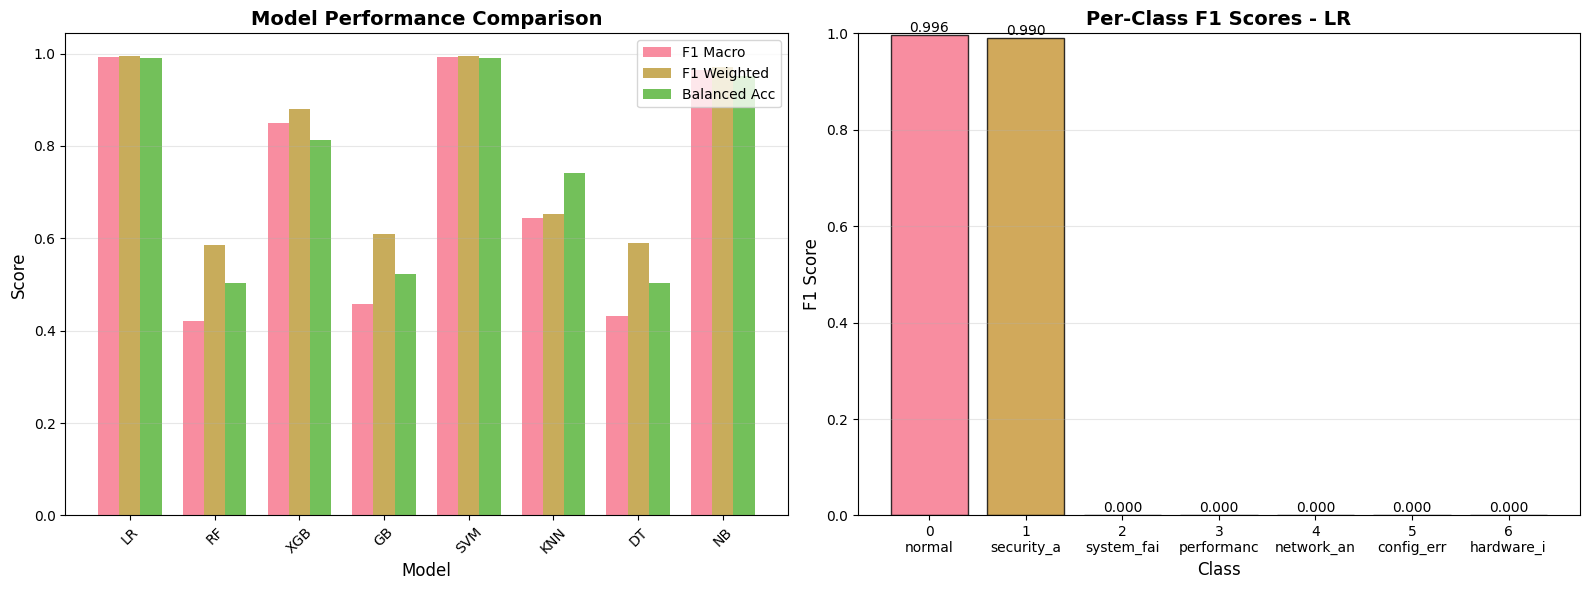


Visualization saved to: C:\Computer Science\AIMLDL\log-anomaly-detection\models\ml_models\model_comparison.png


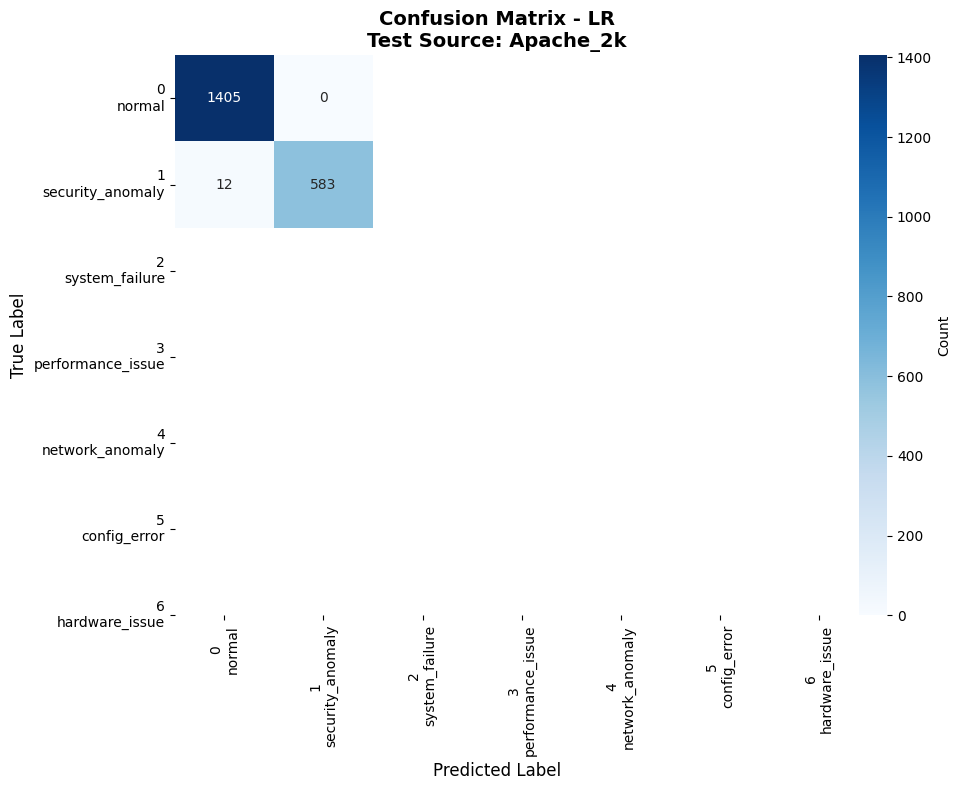

Confusion matrix saved to: C:\Computer Science\AIMLDL\log-anomaly-detection\models\ml_models\confusion_matrix.png


In [ ]:
plt.style.use('default')
sns.set_palette("husl")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ax = axes[0, 0]
models = df_res['mod'].values
metrics = ['f1_macro', 'f1_weighted', 'bal_acc']
metric_names = ['F1 Macro', 'F1 Weighted', 'Balanced Acc']

x = np.arange(len(models))
width = 0.25

for i, (metric, name) in enumerate(zip(metrics, metric_names)):
    values = df_res[metric].values
    ax.bar(x + i*width, values, width, label=name, alpha=0.8)

ax.set_xlabel('Model', fontsize=11)
ax.set_ylabel('Score', fontsize=11)
ax.set_title('Model Performance Comparison', fontsize=13, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels([m.upper() for m in models], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

ax = axes[0, 1]
best_model_metrics = best_row['per_class_f1']
classes = [f"{i}\n{LABEL_MAP[i][:8]}" for i in range(7)]
f1_scores = [best_model_metrics.get(i, 0) for i in range(7)]

bars = ax.bar(classes, f1_scores, color=sns.color_palette("husl", 7), 
              alpha=0.8, edgecolor='black')
ax.set_xlabel('Class', fontsize=11)
ax.set_ylabel('F1 Score', fontsize=11)
ax.set_title(f'Per-Class F1 - {best_model_name.upper()}', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1])

for bar, score in zip(bars, f1_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{score:.2f}', ha='center', va='bottom', fontsize=9)

ax = axes[1, 0]
train_dist = exp_res['train_label_dist']
test_dist = exp_res['test_label_dist']

train_classes = sorted(train_dist.keys())
train_counts = [train_dist[c] for c in train_classes]
test_counts = [test_dist.get(c, 0) for c in train_classes]

x_pos = np.arange(len(train_classes))
width = 0.35

ax.bar(x_pos - width/2, train_counts, width, label='Train', alpha=0.7)
ax.bar(x_pos + width/2, test_counts, width, label='Test', alpha=0.7)

ax.set_xlabel('Class', fontsize=11)
ax.set_ylabel('Count (log scale)', fontsize=11)
ax.set_title('Train vs Test Distribution', fontsize=13, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels([LABEL_MAP[c][:8] for c in train_classes], rotation=45, ha='right')
ax.legend()
ax.set_yscale('log')
ax.grid(axis='y', alpha=0.3)

ax = axes[1, 1]
best_model_result = exp_res['sup'][best_model_name]
cm = np.array(best_model_result['m']['confusion_matrix'])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            cbar_kws={'label': 'Count'})
ax.set_xlabel('Predicted', fontsize=11)
ax.set_ylabel('True', fontsize=11)
ax.set_title(f'Confusion Matrix - {best_model_name.upper()}', fontsize=13, fontweight='bold')
ax.set_xticklabels([LABEL_MAP[i][:8] for i in range(7)], rotation=45, ha='right')
ax.set_yticklabels([LABEL_MAP[i][:8] for i in range(7)], rotation=0)

plt.tight_layout()
plt.savefig(RES_PATH / "comprehensive_results.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Visualizations saved to: {RES_PATH / 'comprehensive_results.png'}")